
# Chapter 8



<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/ISLP_labs/blob/main/Ch08-baggboost-lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/ISLP_labs/blob/main/Ch08-baggboost-lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Lab: Tree-Based Methods

We import some of our usual libraries at this top
level.

In [1]:
%pip install ISLP -qq
%pip install catboost -qq
%pip install dtreeviz -qq

You must restart the runtime in order to use newly installed versions!

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-v0_8-white') #or plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

We also  collect the new imports
needed for this lab.

In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text,
                          export_graphviz)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import graphviz

import time
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [4]:
# Require extra installation
import dtreeviz
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # For dtreeviz

## Fitting Classification Trees

We first use classification trees to analyze the  [`Carseats`](https://islp.readthedocs.io/en/latest/datasets/Carseats.html)  data set.
In these data, `Sales` is a continuous variable, and so we begin
by recoding it as a binary variable. We use the `where()`
function to create a variable, called `High`, which takes on a
value of `Yes` if the `Sales` variable exceeds 8, and takes
on a value of `No` otherwise.

In [ ]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

In [ ]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


We now use `DecisionTreeClassifier()`  to fit a classification tree in
order to predict `High` using all variables but `Sales`.
To do so, we must form a model matrix as we did when fitting regression
models.  

In [ ]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

We have converted `D` from a data frame to an array `X`, which is needed in some of the analysis below. We also need the `feature_names` for annotating our plots later.

There are several options needed to specify the  classifier,
such as `max_depth` (how deep to grow the tree), `min_samples_split`
(minimum number of observations in a node to be eligible for splitting)
and `criterion` (whether to use Gini or cross-entropy as the split criterion).
We also set `random_state` for reproducibility; ties in the split criterion are broken at random.

In [ ]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In our discussion of qualitative features in Section 3.3,
we noted that for a linear regression model such a feature could be
represented by including a matrix of dummy variables (one-hot-encoding) in the model
matrix, using the formula notation of `statsmodels`.
As mentioned in Section 8.1, there is a more
natural way to handle qualitative features when building a decision
tree, that does not require such dummy variables; each split amounts to partitioning the levels into two groups.
However,
the `sklearn` implementation of decision trees does not take
advantage of this approach; instead it simply treats the one-hot-encoded levels as separate variables.

In [ ]:
accuracy_score(High, clf.predict(X))

0.79

With only the default arguments, the training error rate is
21%.
For classification trees, we can
access the value of the deviance using `log_loss()`,
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the $m$th terminal
node that belong to the $k$th class.

In [ ]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.4710647062649358

This is closely related to the *entropy*, defined in (8.7).
A small deviance indicates a
tree that provides a good fit to the (training) data.

One of the most attractive properties of trees is that they can
be graphically displayed. Here we use the `plot()`  function
to display the tree structure.

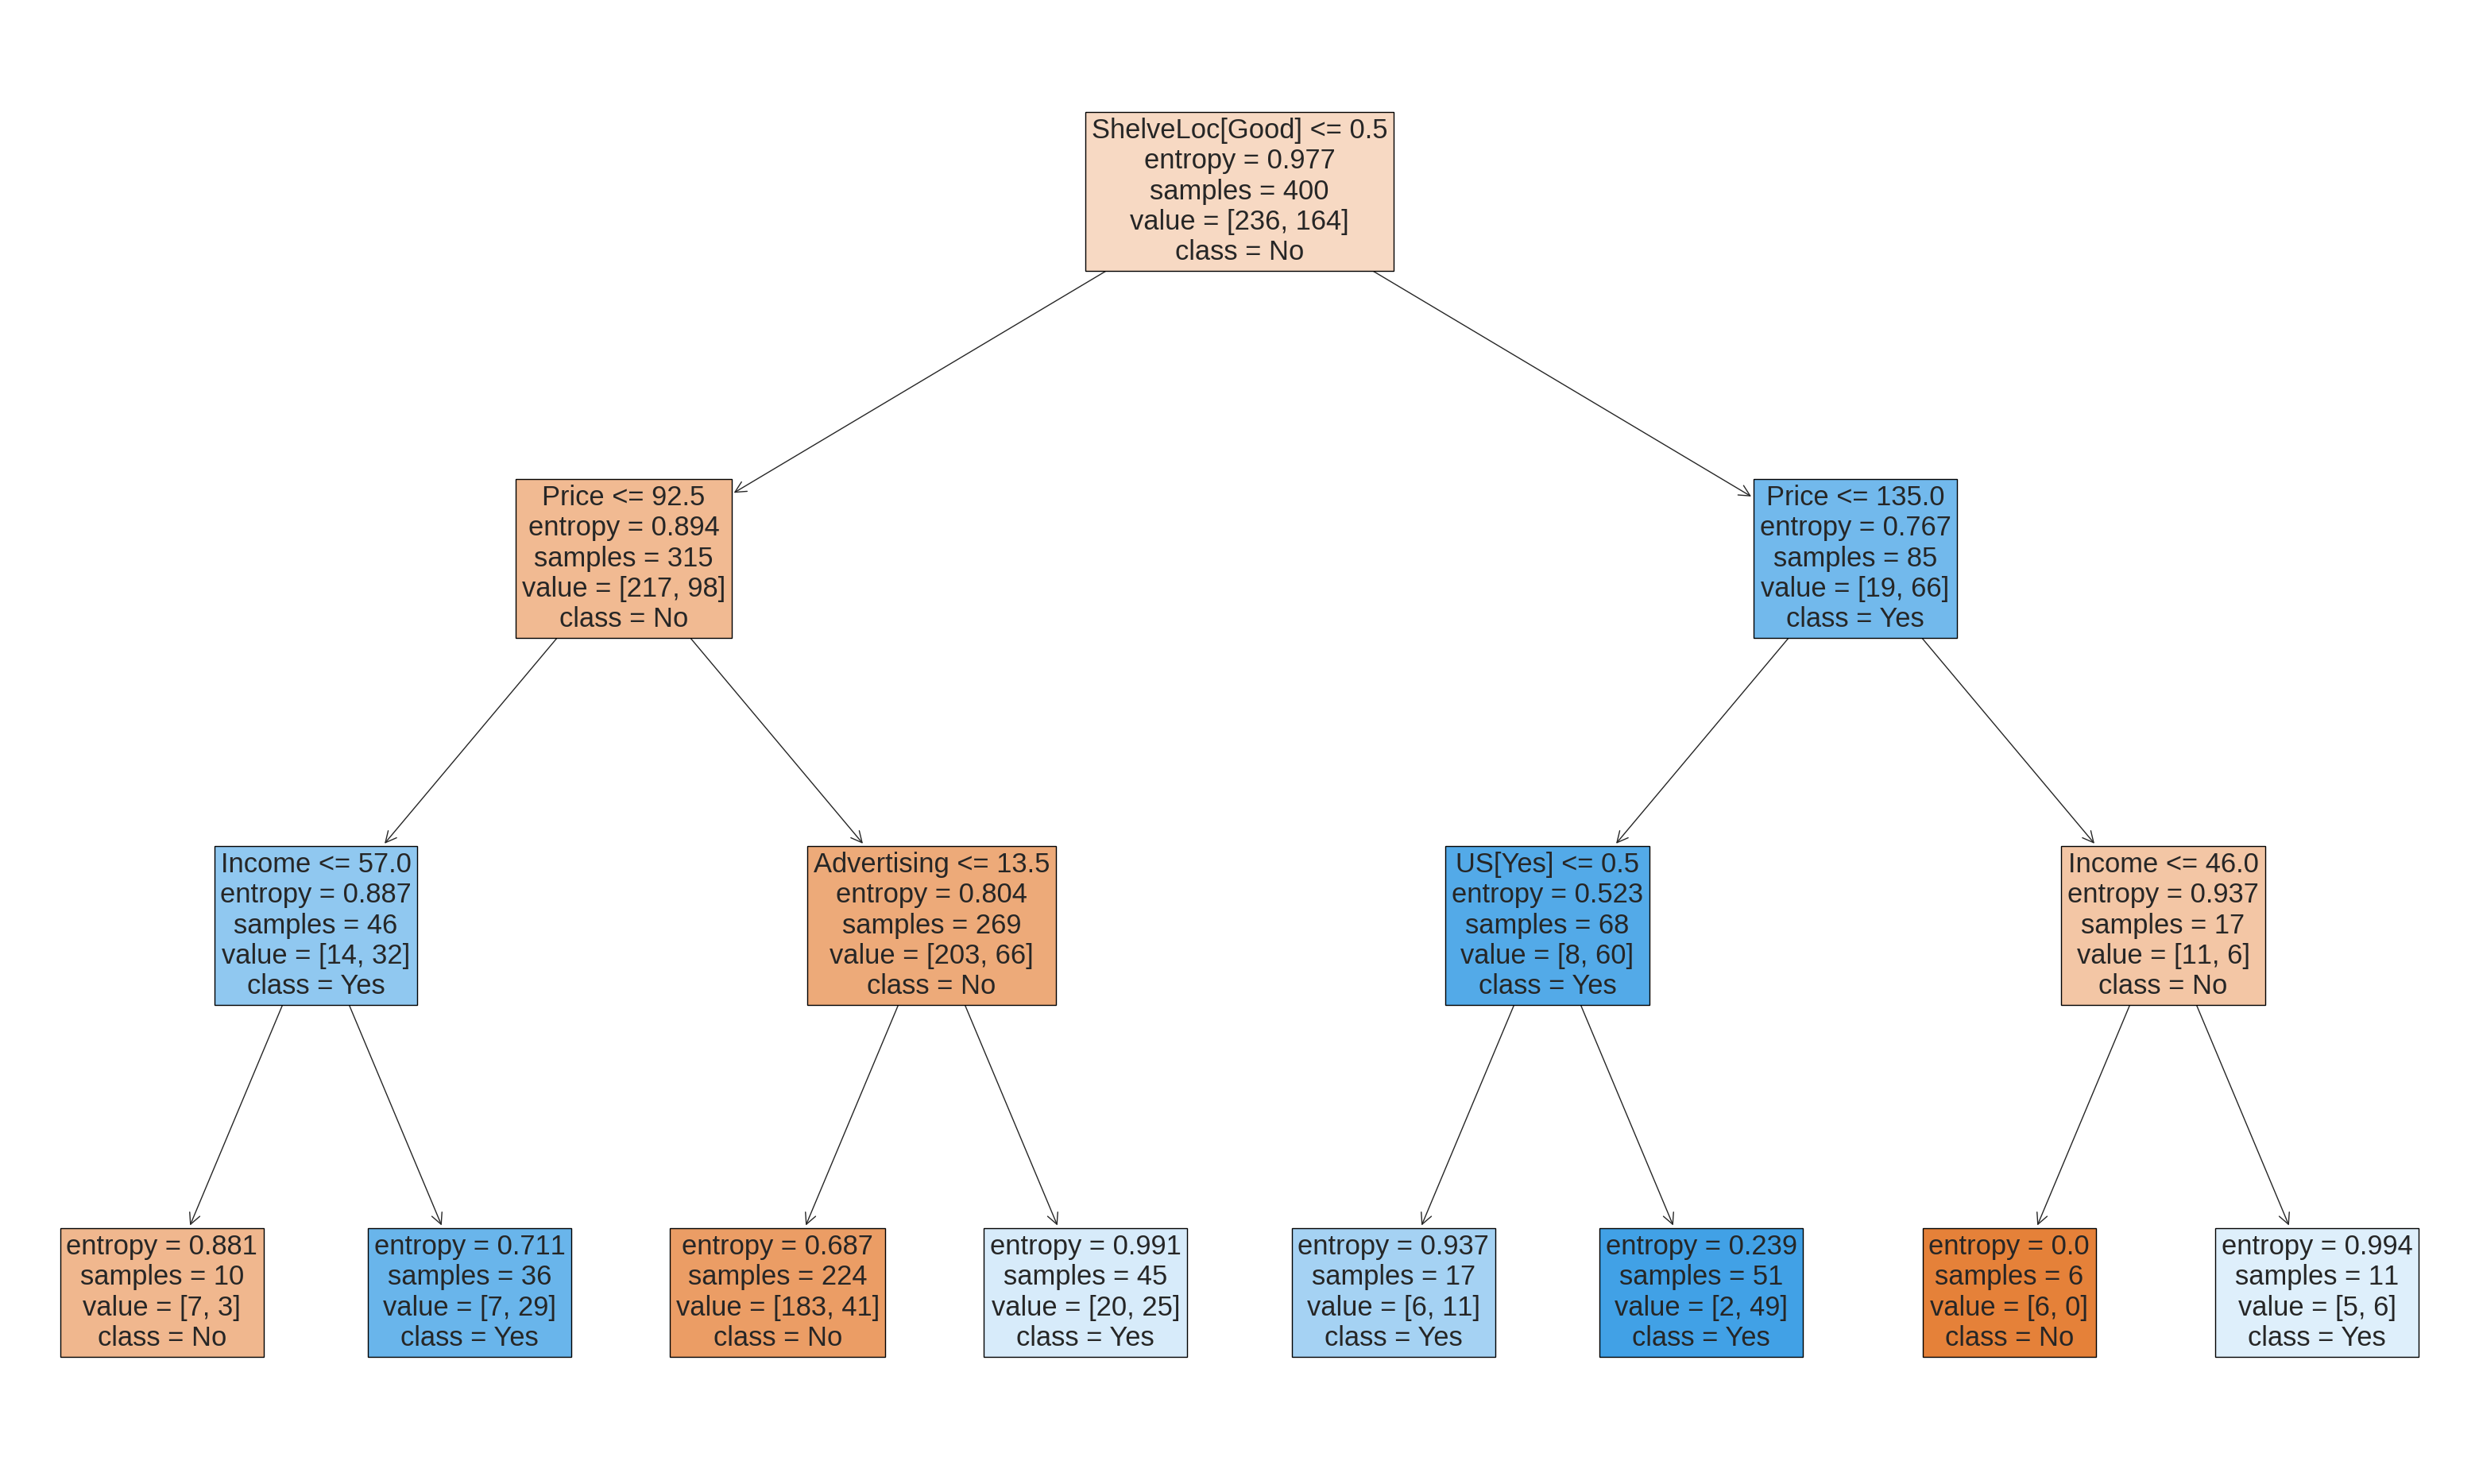

In [ ]:
ax = subplots(figsize=(40,24))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax,
          class_names=['No','Yes'],
          filled=True);

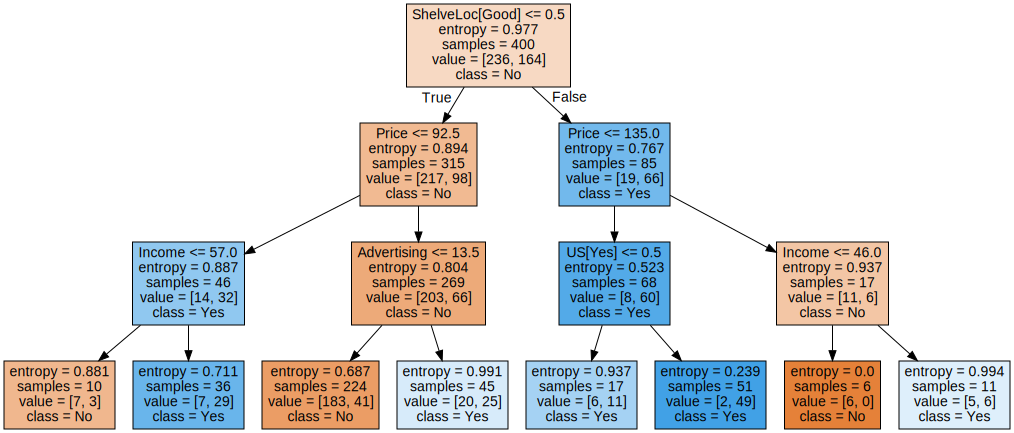

In [ ]:
dot_data = export_graphviz(clf, feature_names=feature_names,
                    class_names=['No','Yes'],
                    filled=True, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("tree1")
graph

In [ ]:
label_encoder = LabelEncoder()
High_encoded = label_encoder.fit_transform(High)

In [ ]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High_encoded)

viz_model = dtreeviz.model(clf,
                           X_train=X,
                           y_train=High_encoded,
                           feature_names = feature_names,
                           target_name='y', class_names=['No','Yes'])

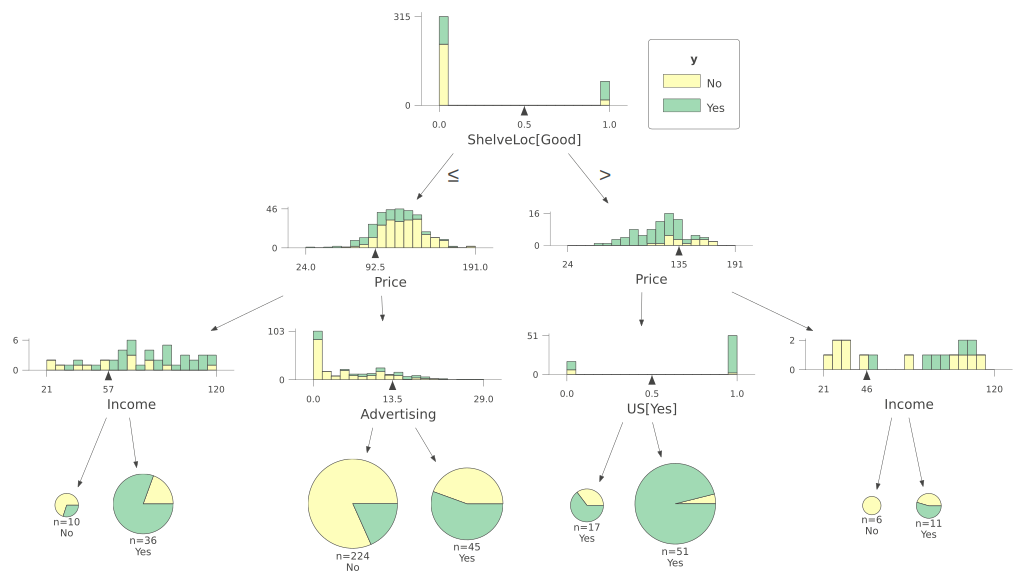

In [ ]:
viz_model.view(scale=1.5)

The most important indicator of `Sales` appears to be `ShelveLoc`.

We can see a text representation of the tree using
`export_text()`, which displays the split
criterion (e.g. `Price <= 92.5`) for each branch.
For leaf nodes it shows the overall prediction  
(`Yes` or `No`).
 We can also see the number of observations in that
leaf that take on values of `Yes` and `No` by specifying  `show_weights=True`.

In [ ]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply
computing the training error. We split the observations into a
training set and a test set, build the tree using the training set,
and evaluate its performance on the test data. This pattern is
similar to that in Chapter 6, with the linear models
replaced here by decision trees --- the code for validation
is almost identical. This approach leads to correct predictions
for 68.5% of the locations in the test data set.

In [ ]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']

array([0.685])

Next, we consider whether pruning the tree might lead to improved
classification performance. We first split the data into a training and
test set. We will use cross-validation to prune the tree on the training
set, and then evaluate the performance of the pruned tree on the test
set.

In [ ]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)

We first refit the full tree on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.


In [ ]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

Next we use the `cost_complexity_pruning_path()` method of
`clf` to extract cost-complexity values.

In [ ]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$ values
from which we can extract an optimal one by cross-validation.

In [ ]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

Let’s take a look at the pruned true.

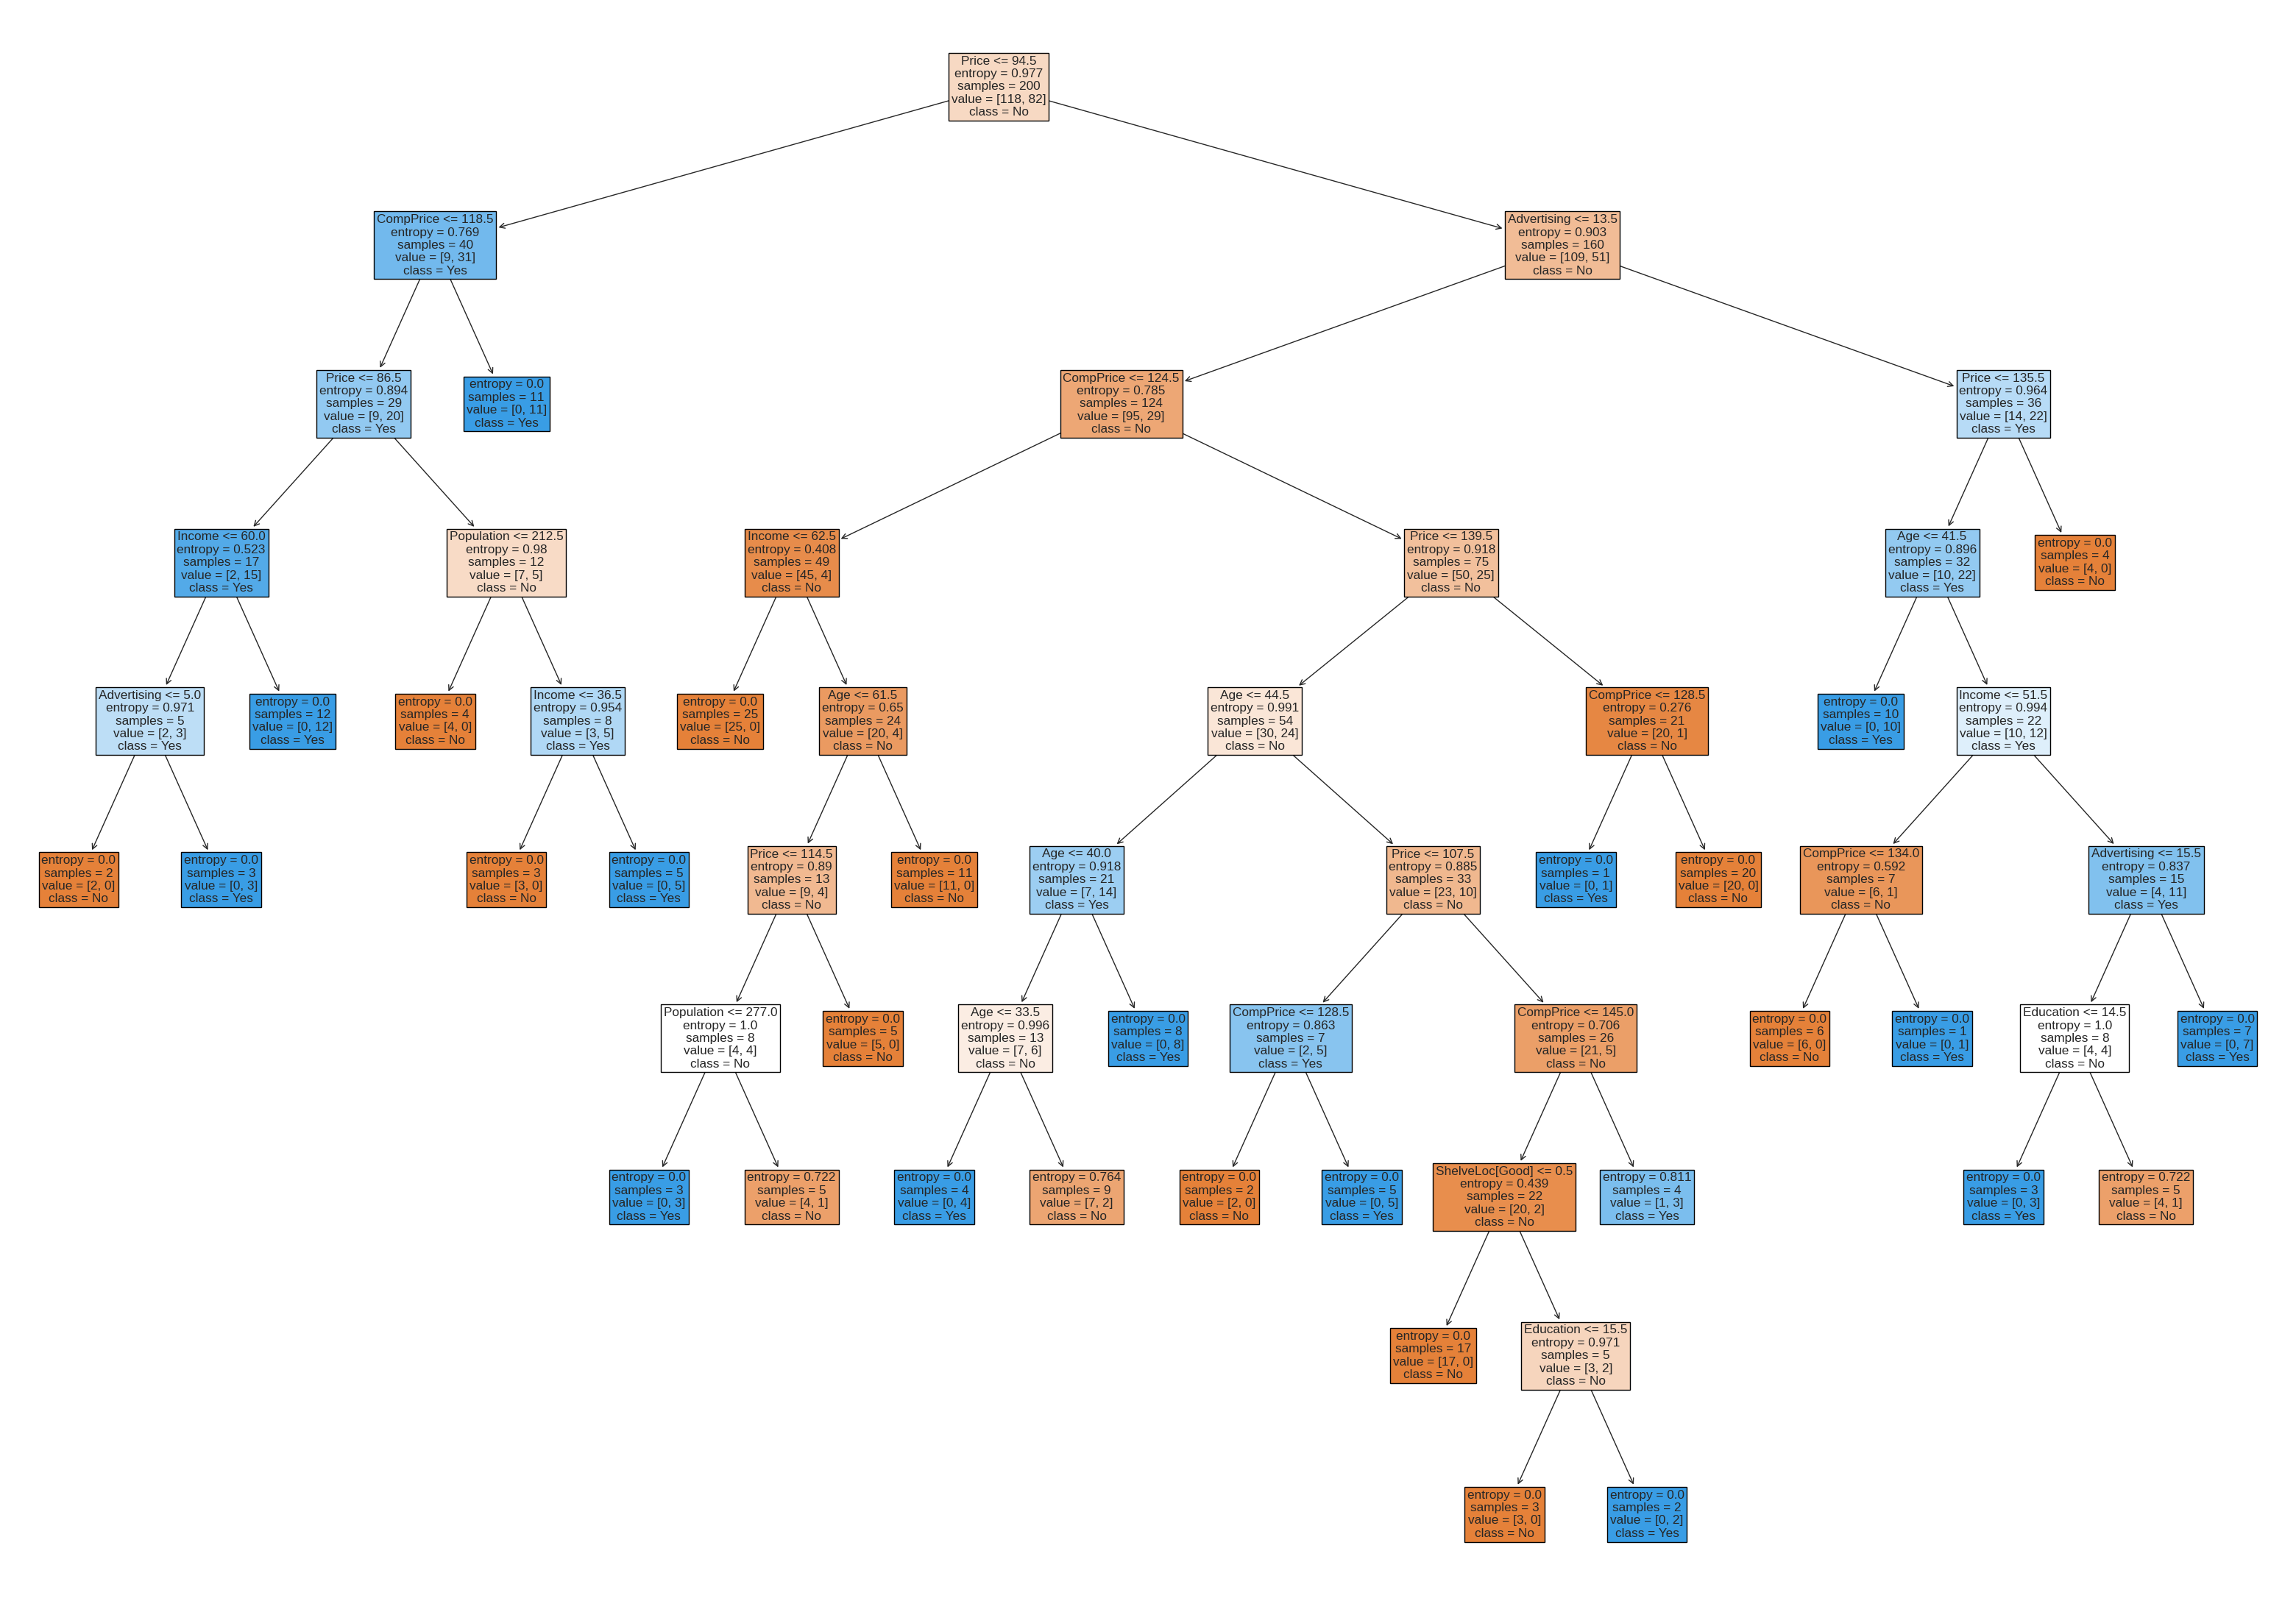

In [ ]:
ax = subplots(figsize=(40, 28))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax,
          class_names=['No','Yes'],
          filled=True);

This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [ ]:
best_.tree_.n_leaves

30

The tree with 30 terminal
nodes results in the lowest cross-validation error rate, with an accuracy of
68.5%. How well does this pruned tree perform on the test data set? Once
again, we apply the `predict()`  function.

In [ ]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). So cross-validation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

  

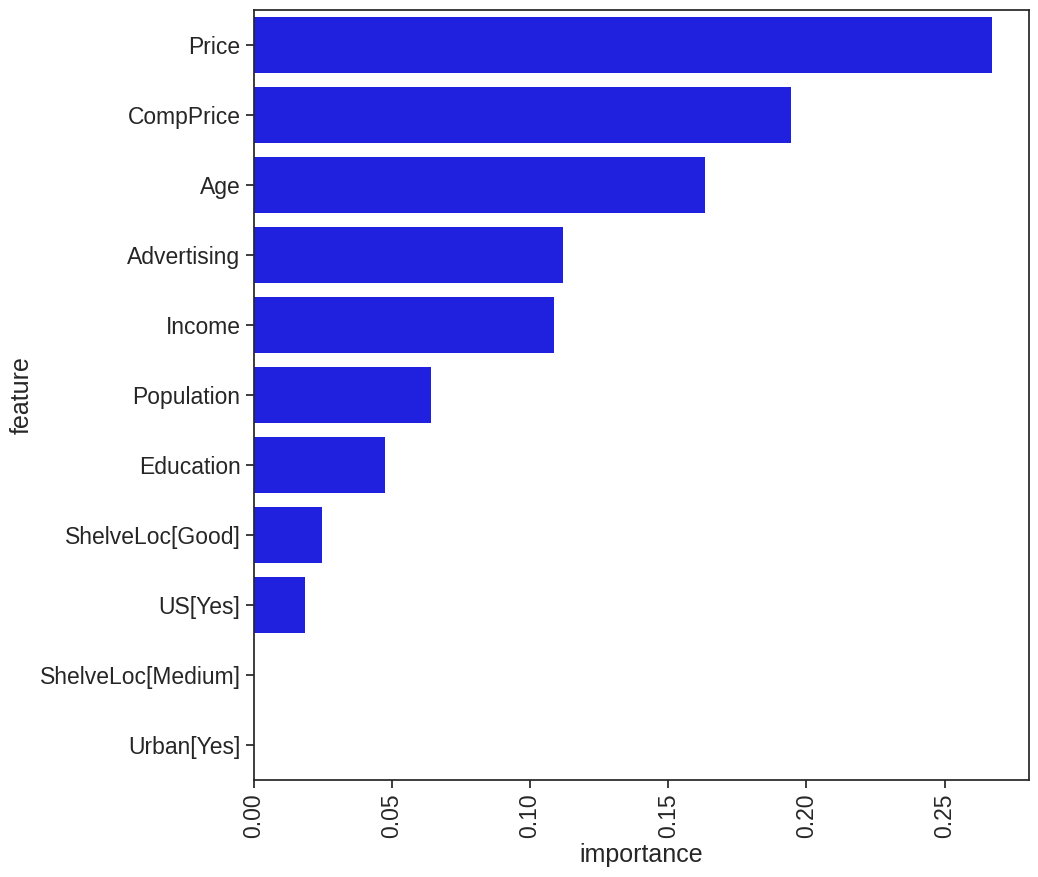

In [ ]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

## Fitting Regression Trees

Here we fit a regression tree to the  `Boston`  data set. The
steps are similar to those for classification trees.

In [ ]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [ ]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

Having formed  our training  and test data sets, we fit the regression tree.

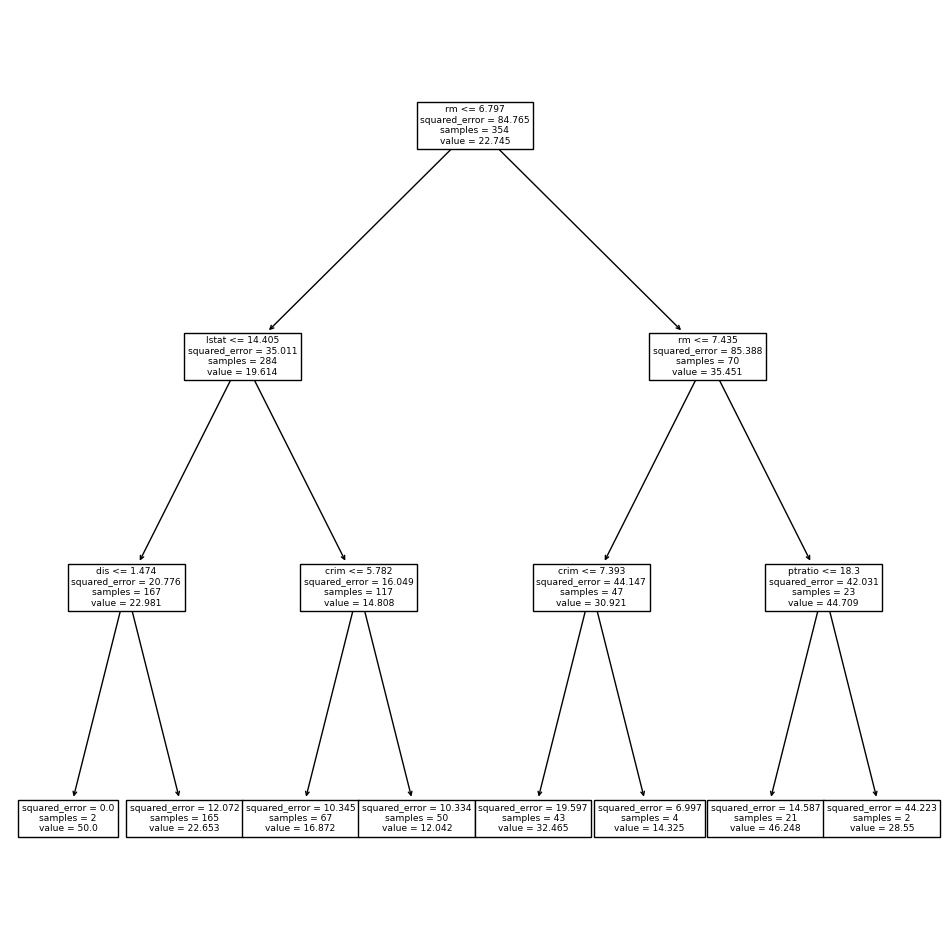

In [ ]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

The variable `lstat` measures the percentage of individuals with
lower socioeconomic status. The tree indicates that lower
values of `lstat` correspond to more expensive houses.
The tree predicts a median house price of $12,042 for small-sized homes (`rm < 6.8`), in
suburbs in which residents have low socioeconomic status (`lstat  > 14.4`) and the crime-rate is moderate (`crim > 5.8`).

Now we use the cross-validation function to see whether pruning
the tree will improve performance.

In [ ]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In keeping with the cross-validation results, we use the pruned tree
to make predictions on the test set.

In [ ]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

In other words, the test set MSE associated with the regression tree
is 28.07.  The square root of
the MSE is therefore around
5.30,
indicating that this model leads to test predictions that are within around
$5300
of the true median home value for the suburb.

Let’s plot the best tree to see how interpretable it is.

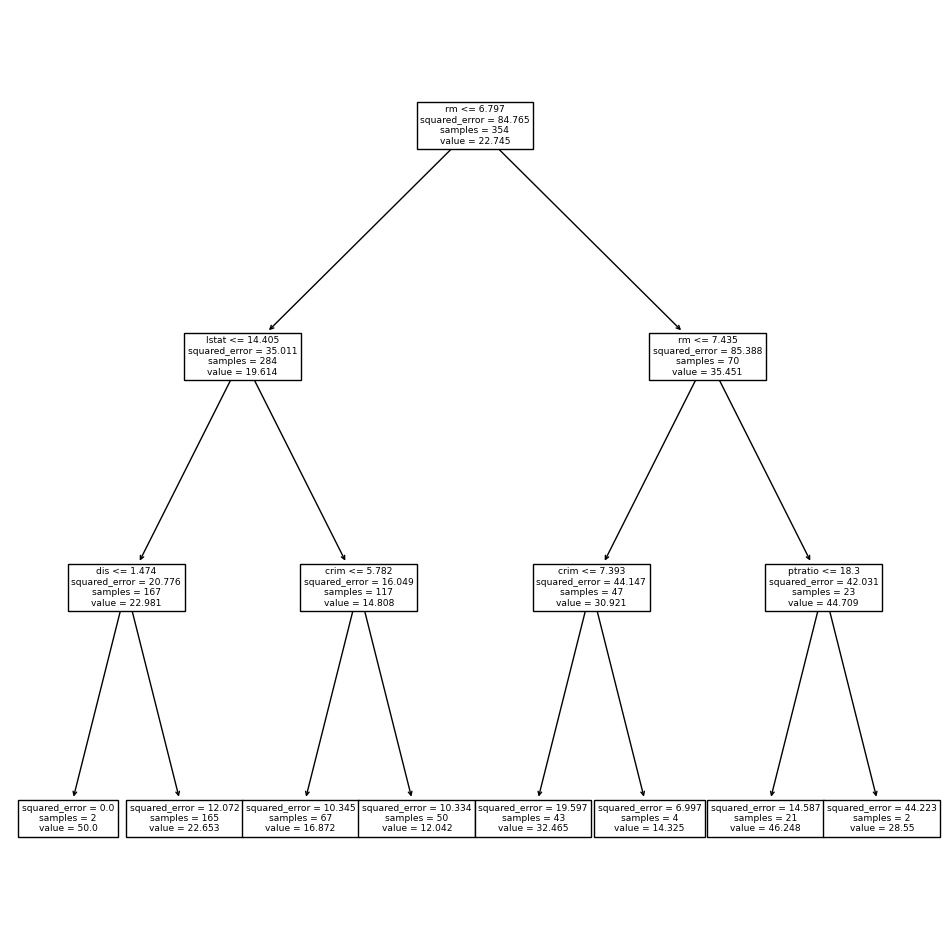

In [ ]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

## Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

In [ ]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

14.634700151315787

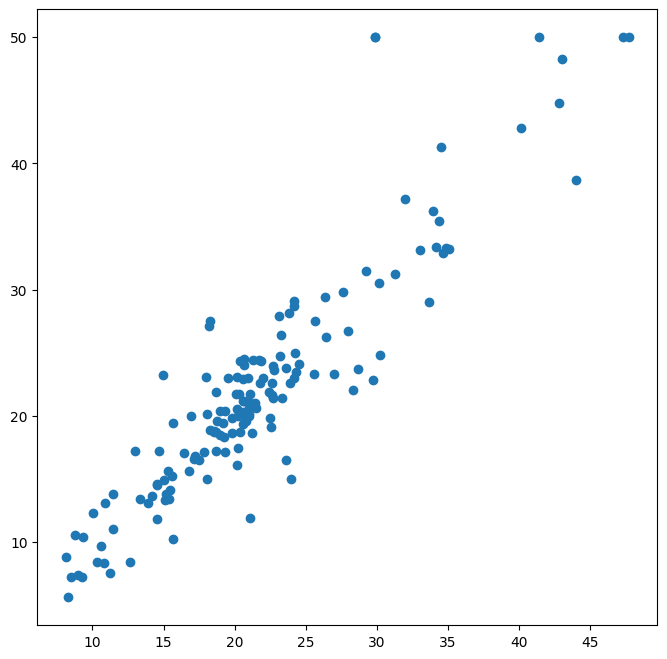

In [ ]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

The test set MSE associated with the bagged regression tree is
14.63, about half that obtained using an optimally-pruned single
tree.  We could change the number of trees grown from the default of
100 by
using the `n_estimators` argument:

In [ ]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `max_features=6`.

In [ ]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

The test set MSE is 20.04;
this indicates that random forests did somewhat worse than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [ ]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees (this was plotted in Figure 8.9 for a model fit to the `Heart` data).

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Boosting

Here we use `GradientBoostingRegressor()` from `sklearn.ensemble`
to fit boosted regression trees to the `Boston` data
set. For classification we would  use `GradientBoostingClassifier()`.
The argument `n_estimators=5000`
indicates that we want 5000 trees, and the option
`max_depth=3` limits the depth of each tree. The
argument `learning_rate` is the $\lambda$
mentioned earlier in the description of boosting.

In [ ]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

We can see how the training error decreases with the `train_score_` attribute.
To get an idea of how the test error decreases we can use the
`staged_predict()` method to get the predicted values along the path.

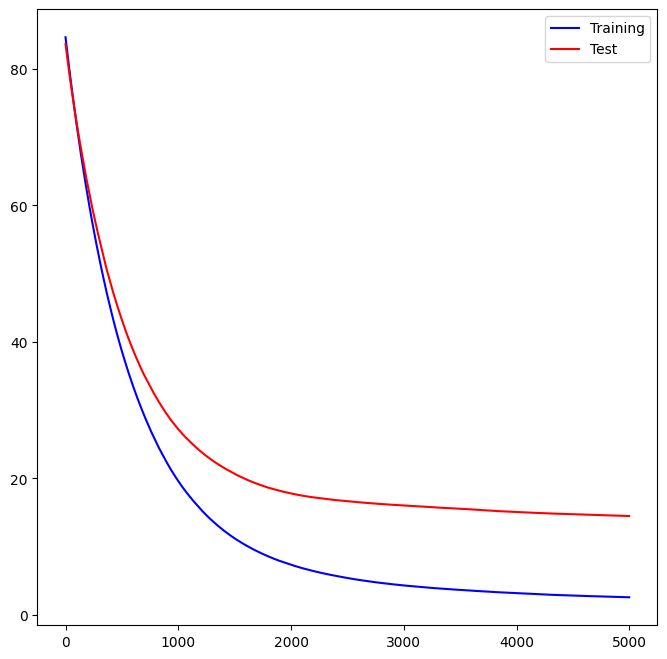

In [ ]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

We now use the boosted model to predict `medv` on the test set:

In [ ]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

 The test MSE obtained is 14.48,
similar to the test MSE for bagging. If we want to, we can
perform boosting with a different value of the shrinkage parameter
$\lambda$ in  (8.10). The default value is 0.001, but
this is easily modified.  Here we take $\lambda=0.2$.

In [ ]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

In this case, using $\lambda=0.2$ leads to a almost the same test MSE
as when using $\lambda=0.001$.



## Bayesian Additive Regression Trees

In this section we demonstrate a  `Python` implementation of BART found in the
`ISLP.bart` package. We fit a  model
to the `Boston` housing data set. This `BART()` estimator is
designed for quantitative outcome variables, though other implementations are available for
fitting logistic and probit models to categorical outcomes.

In [ ]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

On this data set, with this split into test and training, we see that the test error of BART is similar to that of  random forest.

In [ ]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

20.739185417498764

We can check how many times each variable appeared in the collection of trees.
This gives a summary similar to the variable importance plot for boosting and random forests.

In [ ]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion

crim       25.466667
zn         30.600000
indus      24.933333
chas       21.133333
nox        27.333333
rm         28.800000
age        23.466667
dis        26.000000
rad        25.000000
tax        21.733333
ptratio    26.800000
lstat      31.866667
dtype: float64

## XGBoost

### Classification task

Here are the essential steps to build an XGBoost classification model in scikit-learn using cross-validation.

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

The following template is for building an XGBoost classifier

In [ ]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob',
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

1. `booster='gbtree'`: The booster is the base learner. It's the machine learning model that is constructed during every round of boosting. You may have guessed that 'gbtree' stands for gradient boosted tree, the XGBoost default base learner. It's uncommon but possible to work with other base learners,

2. `objective='multi:softprob'`: Standard options for the objective can be viewed in the XGBoost official documentation, https://xgboost.readthedocs.io/en/latest/parameter.html, under Learning Task Parameters. The multi:softprob objective is a standard alternative to binary:logistic when the dataset includes multiple classes. It computes the probabilities of classification and chooses the highest one. If not explicitly stated, XGBoost will often find the right objective for you.

3. `max_depth=6`: The max_depth of a tree determines the number of branches each tree has. It's one of the most important hyperparameters in making balanced predictions. XGBoost uses a default of 6, unlike random forests, which don't provide a value unless explicitly programmed.

3. `learning_rate=0.1`: Within XGBoost, this hyperparameter is often referred to as eta. This hyperparameter limits the variance by reducing the weight of each tree to the given percentage.

4. `n_estimators=100`: Popular among ensemble methods, `n_estimators` is the number of boosted trees in the model. Increasing this number while decreasing `learning_rate` can lead to more robust results.

In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
xgb.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Regression task

Here are the essential steps to build an XGBoost regression model in scikit-learn using cross-validation.

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [63.033 59.689 64.538 63.699 64.661]
RMSE mean: 63.124


In [ ]:
xgb.fit(X,y)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Without a baseline of comparison, we have no idea what that score means. Converting the target column, `y`, into a pandas DataFrame with the `.describe()` method will give the quartiles and the general statistics of the predictor column, as follows:

In [ ]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


A score of 63.124 is less than 1 standard deviation, a respectable result.

### Speed comparsion

Let's now compare `GradientBoostingClassifier` and `XGBoostClassifier` with the [exoplanet dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) for its speed

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv

--2022-11-08 09:14:53--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv [following]
--2022-11-08 09:14:53--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [text/plain]
Saving to: ‘exopla

In [ ]:
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9874213836477987
Run Time: 318.0388216972351 seconds


In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
xg_reg = XGBClassifier(n_estimators=100, max_depth=2, random_state=42)

# class column has to start from 0 (as required since version 1.3.2).
le = LabelEncoder() # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Fit xg_reg to training set
xg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 71.92710447311401 seconds


When it comes to big data, an algorithm five as fast can save weeks or months of computational time and resources! This advantage is huge in the world of big data. In the world of boosting, XGBoost is the model of choice due to its unparalleled speed and impressive accuracy.

### Hyperparameter

XGBoost has many hyperparameters. XGBoost base learner hyperparameters incorporate all decision tree hyperparameters as a starting point. There are gradient boosting hyperparameters, since XGBoost is an enhanced version of gradient boosting.

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv

--2022-11-08 09:22:39--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv [following]
--2022-11-08 09:22:39--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘he

In [ ]:
df = pd.read_csv('heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# Split data into X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Before tuning hyperparameters, let's build a classifier so that we can obtain a baseline score as a starting point.

When fine-tuning hyperparameters, GridSearchCV and RandomizedSearchCV are the standard options. However, `cross_val_score` and `GridSearchCV/RandomizedSearchCV` do not split data the same way. One solution is to use `StratifiedKFold` whenever cross-validation is used.

A stratified fold includes the same percentage of target values in each fold. If a dataset contains 60% 1s and 40% 0s in the target column, each stratified test set contains 60% 1s and 40% 0s. When folds are random, it's possible that one test set contains a 70-30 split while another contains a 50-50 split of target values.

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# The 'binary:logistic' objective is standard for binary classification in determining the loss function
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.85 0.72 0.74 0.82 0.78]
Accuracy mean: 0.78


The point here is to use the same folds to obtain new scores when fine-tuning hyperparameters with GridSearchCV and RandomizedSearchCV so that the comparison of scores is fair.

In [ ]:
def grid_search(params, random=False):

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)

    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)

    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

The XGBoost hyperparameters presented here are not meant to be exhaustive, but they are meant to be comprehensive. For a complete list of hyperparameters, read the official documentation, XGBoost Parameters, at https://xgboost.readthedocs.io/en/latest/parameter.html.

#### learning_rate

`learning_rate` shrinks the weights of trees for each round of boosting. By lowering `learning_rate`, more trees are required to produce better scores. Lowering `learning_rate` prevents overfitting because the size of the weights carried forward is smaller.

A default value of 0.3 is used. Here is a starting range for `learning_rate` as placed inside our grid_search function:

In [ ]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.5}
Best score: 0.80525


lowering `learning_rate` may be advantageous when `n_estimators` goes up.

#### max_depth

`max_depth` determines the length of the tree, equivalent to the number of rounds of splitting. Limiting `max_depth` prevents overfitting because the individual trees can only grow as far as `max_depth` allows. XGBoost provides a default `max_depth` value of six:

In [ ]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 2}
Best score: 0.79552


Changing `max_depth` from 6 to 2 gave a better score. The lower value for `max_depth` means variance has been reduced.

#### gamma

Known as a Lagrange multiplier, `gamma` provides a threshold that nodes must surpass before making further splits according to the loss function. There is no upper limit to the value of `gamma`. The default is 0, and anything over 10 is considered very high. Increasing `gamma` results in a more conservative model:

In [ ]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Best params: {'gamma': 1}
Best score: 0.79880


Changing gamma from 0 to 1 has resulted in a slight improvement.

#### min_child_weight

`min_child_weight` refers to the minimum sum of weights required for a node to split into a child. If the sum of the weights is less than the value of `min_child_weight`, no further splits are made. `min_child_weight` reduces overfitting by increasing its value:

In [ ]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Best params: {'min_child_weight': 5}
Best score: 0.81202


A slight adjustment to `min_child_weight` form 1 to 5 gives the best results yet.

#### subsample

The `subsample` hyperparameter limits the percentage of training instances (rows) for each boosting round. Decreasing `subsample` from 100% reduces overfitting:

In [ ]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.5}
Best score: 0.82525


The score has improved by a slight amount once again, indicating a small presence of overfitting.

#### colsample_bytree

Similar to `subsample`, `colsample_bytree` randomly selects particular columns according to the given percentage. `colsample_bytree` is useful for limiting the influence of columns and reducing variance. Note that `colsample_bytree` takes a percentage as input, not the number of columns:

In [ ]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'colsample_bytree': 0.5}
Best score: 0.79874


You are encouraged to try `colsample_bylevel` and `colsample_bynode` on your own. `colsample_bylevel` randomly selects columns for each tree depth, and `colsample_bynode` randomly selects columns when evaluating each tree split.

#### n_estimators

Recall that `n_estimators` provides the number of trees in the ensemble. In the case of XGBoost, `n_estimators` is the number of trees trained on the residuals. Initialize a grid search of `n_estimators` with the default of 100, then double the number of trees through 800 as follows:

In [ ]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params: {'n_estimators': 200}
Best score: 0.79219


Since our dataset is small, increasing `n_estimators` did not produce better results.

#### Applying early stopping

`early_stopping_rounds` is not a hyperparameter, but a strategy for optimizing the `n_estimators` hyperparameter.

Normally when choosing hyperparameters, a test score is given after all boosting rounds are complete. To use early stopping, we need a test score after each round. `eval_metric` and `eval_set` may be used as parameters for `.fit` to generate test scores for each training round. `eval_metric` provides the scoring method, commonly 'error' for classification, and 'rmse' for regression. `eval_set` provides the test to be evaluated, commonly X_test and y_test.

The following steps display an evaluation metric for each round of training with the default `n_estimators=100:`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-error:0.17105
[32]	validation_0-error:0.18421
[33]	validation_0-error:0.18421
[34]	validation_0-error:0.18421
[35]	validation_0-error:0.17105
[36]	validation_0-error:0.17105
[37]	validation_0-error:0.17105
[38]	validation_0-error:0.18421
[39]	validation_0-error:0.17105
[40]	validation_0-error:0.18421
[41]	validation_0-error:0.18421
[42]	validation_0-error:0.18421
[43]	validation_0-error:0.18421
[44]	val

We know that `StratifiedKFold` cross-validation gives a mean accuracy of 78% when n_estimators=100. The disparity in scores comes from the difference in test sets.

#### early_stopping_rounds

`early_stopping_rounds` is an optional parameter to include with `eval_metric` and `eval_set` when fitting a model. Let's try `early_stopping_rounds=10`.
The previous code is repeated with `early_stopping_rounds=10` added in:

In [ ]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10, verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
Accuracy: 82.89%


A more thorough approach is to use larger values, say, `n_estimators = 5000` and `early_stopping_rounds=100`. By setting `early_stopping_rounds=100`, you are guaranteed to reach the default of 100 boosted trees presented by XGBoost.
Here is the code that gives a maximum of 5,000 trees and that will stop after 100 consecutive rounds fail to find any improvement:

In [ ]:
model = XGBClassifier(random_state=42, n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=100)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-error:0.17105
[32]	validation_0-error:0.18421
[33]	validation_0-error:0.18421
[34]	validation_0-error:0.18421
[35]	validation_0-error:0.17105
[36]	validation_0-error:0.17105
[37]	validation_0-error:0.17105
[38]	validation_0-error:0.18421
[39]	validation_0-error:0.17105
[40]	validation_0-error:0.18421
[41]	validation_0-error:0.18421
[42]	validation_0-error:0.18421
[43]	val

After 100 rounds of boosting, the score provided by 13 trees is the best.

#### Automatically hyperparamter tuning

You are encourage to try https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py for hyperparameter tuning.

### For categorical variable and missing value

XGBoost has experiment support for categorical variable, you can check out here: https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html. But it only works for a few tree methods, it is still recommend to encode your data https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques/notebook. Missing value, on the other hand can be handled by XGBoost as described at https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values.

In [ ]:
!gdown 1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH

Downloading...
From: https://drive.google.com/uc?id=1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH
To: /content/melb_data.csv
100% 2.09M/2.09M [00:00<00:00, 36.3MB/s]


In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                    random_state=42, n_jobs=-1) # You can either specify missing=-9999 or leave it as it is
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
preds = xgb.predict(X_valid)

In [ ]:
mean_absolute_error(y_valid, preds)

173639.76325478646

## Lightgbm

### Classification task

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [ ]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Regression task

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

lgbr = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(lgbr, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [56.081 59.172 63.191 61.833 60.542]
RMSE mean: 60.164


In [ ]:
lgbr.fit(X,y)
lgbr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Speed

In [ ]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
lg_reg = lgb.LGBMClassifier(n_estimators=100, max_depth=2, random_state=42)

# Fit xg_reg to training set
lg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = lg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 10.266663074493408 seconds


### Hyperparameter

Following set of practices can be used to improve your model efficiency.

* **num_leaves** : This is the main parameter to control the complexity of the tree model. Ideally, the value of `num_leaves` should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.

* **min_data_in_leaf** : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

* **max_depth** : We also can use `max_depth` to limit the tree depth explicitly.

1. **For Faster Speed**

* Use bagging by setting `bagging_fraction` and `bagging_freq`.
* Use feature sub-sampling by setting `feature_fraction`.
* Use small `max_bin`.
* Use `save_binary` to speed up data loading in future learning.

2. **For better accuracy**

* Use large `max_bin` (may be slower).
* Use small `learning_rate` with `large num_iterations`
* Use large `num_leaves`(may cause over-fitting)
* Try to use categorical feature directly.

3. **To deal with over-fitting**

* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to regularization
* Try `max_depth` to avoid growing deep tree
* Try `dart`

Check https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html for hyperparamter tuning.

### For categorical variable and missing value

LightGBM enables the missing value handle by default. See https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle. It also deal with categorical variables as described here https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support

In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42, n_jobs=-1)
lgbr.fit(X, y_train)

LGBMRegressor(random_state=42)

In [ ]:
preds = lgbr.predict(X_v)

In [ ]:
mean_absolute_error(y_valid, preds)

160267.37406568974

## CatBoost

In this section, we would explore some base cases of using catboost, such as model training, cross-validation and predicting

### Classification task

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [ ]:
clf = CatBoostClassifier(boosting_type='Plain', learning_rate=0.1, n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent')
clf.fit(X_train, y_train)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'class_names': [0, 1, 2],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.10000

### Regression

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

catb = CatBoostRegressor(boosting_type='Plain', learning_rate=0.1, random_state=42, n_estimators=100, thread_count=-1, logging_level = 'Silent')

scores = cross_val_score(catb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [54.744 56.125 59.595 56.908 56.583]
RMSE mean: 56.791


In [ ]:
catb.fit(X,y)
catb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': '

### Speed

In [ ]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
ca_reg = CatBoostClassifier(n_estimators=100, max_depth=2, random_state=42, logging_level = 'Silent')

# Fit xg_reg to training set
ca_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = ca_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 16.69258213043213 seconds


### Hyperparameter

You can check more details at https://catboost.ai/en/docs/references/training-parameters/. There are also tutorials about hyperparameter tuning https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb

### For categorical variable and missing value

One of the differences between CatBoost and other gradient boosting libraries is its advanced processing of the categorical features (in fact "Cat" in the package name stands for "CATegorical").

CatBoost deals with the categorical data quite well out-of-the-box. However, it also has a huge number of training parameters, which provide fine control over the categorical features preprocessing.

The amount of parameters related to categorical features processing in CatBoost is overwhelming. Here is a hopefully the full list:

* `one_hot_max_size` (int) - use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. No complex encoding is performed for such features.

* `model_size_reg` (float from 0 to inf) - The model size regularization coefficient. The larger the value, the smaller the model size. This regularization is needed only for models with categorical features (other models are small). Models with categorical features might weight tens of gigabytes or more if categorical features have a lot of values. If the value of the regularizer differs from zero, then the usage of categorical features or feature combinations with a lot of values has a penalty, so fewer of them are used in the resulting model. Default value is 0.5

* `max_ctr_complexity` - The maximum number of features that can be combined. Each resulting combination consists of one or more categorical features and can optionally contain binary features in the following form: “numeric feature > value”. For regression task on CPU the default value is 4.

* `has_time (bool)` - if true, the 1-st step of categorical features processing, permutation, is not performed. Useful when the objects in your dataset are ordered by time. For our dataset, we don't need it. Default value is False

* `simple_ctr` - Quantization settings for simple categorical features.
combinations_ctr - Quantization settings for combinations of categorical features.

* `per_feature_ctr` - Per-feature quantization settings for categorical features.

* `counter_calc_method` determines whether to use validation dataset (provided through parameter eval_set of fit method) to estimate categories frequencies with Counter. By default, it is Full and the objects from validation dataset are used; Pass SkipTest value to ignore the objects from the validation set
ctr_target_border_count - The maximum number of borders to use in target quantization for categorical features that need it. Default for regression task is 1.

* `ctr_leaf_count_limit` - The maximum number of leaves with categorical features. Default value is None i.e. no limit.

* `store_all_simple_ctr`- If the previous parameter ctr_leaf_count_limit at some point gradient boosting tree can no longer make splits by categorical features. With Default value False the limitation applies both to original categorical features and the features, that CatBoost creates by combining different features. If this parameter is set to True only the number of splits made on combination features is limited.

The three parameters `simple_ctr`, `combinations_ctr`, and `per_feature_ctr` are complex parameters that control the second and the third steps of categorical features processing.

In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
categorical_features_names = list(X_train_cat.columns)

for col in categorical_features_names:
  X[col] = X.loc[:,col].fillna(value='nan')
  X_v[col] = X_v.loc[:,col].fillna(value='nan')
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

In [ ]:
preds = catbr.predict(X_v)

In [ ]:
mean_absolute_error(y_valid, preds)

164721.46472522244

The first thing we try is to make CatBoost use one-hot encoding for all our categorical features. The documentation says, that for the features for which one-hot encoding is used no other encodings are computed.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, one_hot_max_size=500)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163165.1377008556

Let us try to set model size regularization coefficient to 0 - thus we allow our model to use as many categorical features and its combinations as it wants.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

165007.46639148306

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=1)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

160827.54657606702

Note that any combination of several categorical features could be considered as a new one. Although it is not mentioned in the documentation, this parameter value has to be smaller than 15.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=6)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163529.3517553931

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164721.46472522244

Counter method is very similar to the traditional Frequency Encoding

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Counter', combinations_ctr='Counter')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164993.47954656056

Now we proceed to the settings of the encodings methods that require target quantization. The first choice is `Borders` vs. Buckets

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Borders', combinations_ctr='Borders')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166920.94141120723

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Buckets', combinations_ctr='Buckets')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

168168.9386958123

It is quite common to use several encodings for a categorical feature. For instance, CatBoost creates 4 different encodings for each categorical feature by default. By default, CatBoost uses several encoding techniques to encode each categorical feature.

* First it uses `Borders` method with one target border `TargetBorderCount=1` (in our example for each categorical feature we just want to see if it makes the car more expensive). The obtained float encodings are further discretized into `CtrBorderCount=15` different values. Three values of Prior parameter are used to create 3 three different encodings: `Prior=0/1:Prior=0.5/1:Prior=1/1`

* Also for each categorical feature, we create an encoding with Counter method. The number of categorical encoding value borders `CtrBorderCount` is also equal to 15, and only one value of `Prior=0/1` is used.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, ctr_target_border_count=10)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166281.68070428775

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

## Voting and Stacking

In [ ]:
Carseats = pd.read_csv('/content/drive/MyDrive/Lab/Data/Carseats.csv')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True) #sklearn does not have built-in support for categorical variable
y = Carseats["High"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

(400, 11)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf1 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=10))
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

estimators = [
    ("knn", clf1),
    ("dc", clf2),
    ("nb", clf3)
]

vclf = VotingClassifier(estimators=estimators, voting='hard')

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

print('5-fold cross validation:\n')


for clf, label in zip([clf1, clf2, clf3, vclf],
                      ['KNN',
                       'DecisionTreeClassifier',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.82 (+/- 0.04) [StackingClassifier]


Check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html for more details

In [ ]:
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'DecisionTreeClassifier',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.81 (+/- 0.05) [StackingClassifier]


Check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html or http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#stackingcvclassifier for more details